(768, 1024)
(423, 419)


Text(0.5, 1.0, 'sudoku')

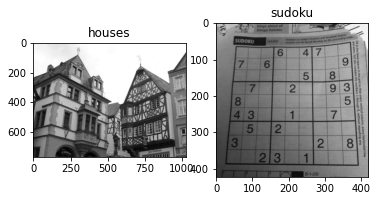

In [1]:
# Notebook Code preparation

# Importing required libraries
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import cv2

# import the images
houses = cv2.cvtColor(cv2.imread("houses.jpg"),cv2.COLOR_BGR2GRAY)
sudoku = cv2.cvtColor(cv2.imread("sudoku.jpg"),cv2.COLOR_BGR2GRAY)

# sometimes to avoid writing the same code twice I will be using an array of the images
img_arr = [houses, sudoku]
title_arr = ["houses", "sudoku"]

# check their shapes to ensure they are in black and white
print(houses.shape)
print(sudoku.shape)

# Display the images to get an idea of their original look
f, axarr = plt.subplots(1,2)

# Display the houses
axarr[0].imshow(houses, cmap = 'gray')
axarr[0].set_title("houses")

# Display the sudoku
axarr[1].imshow(sudoku, cmap = 'gray')
axarr[1].set_title("sudoku")

# 1.1 Global Binary Threshold

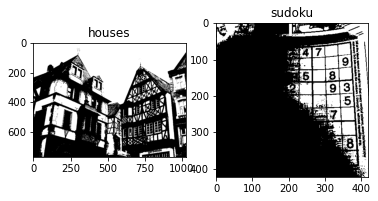

In [2]:

# Create empty images based on the shapes of images in img_arr
global_bin_threshold_imgs = [np.zeros(img.shape, np.uint8) for img in img_arr]

# this loop iterates through images
for img_index in range(0,len(img_arr)):
    # this loops iterates through an image's rows
    for row_index in range(0, img_arr[img_index].shape[0]):
        # this loop iterates through the row's pixels
        for pixel in range(0, img_arr[img_index].shape[1]):
            if img_arr[img_index][row_index][pixel] > 127:
                global_bin_threshold_imgs[img_index][row_index][pixel] = 255
            else:
                global_bin_threshold_imgs[img_index][row_index][pixel] = 0
                
# plot results
_, axarr = plt.subplots(1,2)
for img, plot, title in zip(global_bin_threshold_imgs, axarr, title_arr):
    plot.imshow(img, cmap = 'gray')
    plot.set_title(title)


# 1.2 Global Binary Threshold, Trackbar Input
 I noticed that the trackbar is very laggy, please be patient when playing with it. Press any key to close and continue the execution of the notebook

In [3]:
default_threshold = 127

# houses trackbar
houses_trackbar_thresh = np.zeros(houses.shape, np.uint8) 
houses_window_name = "houses_window"
cv2.namedWindow(houses_window_name)

def on_trackbar_houses(val):
    # this loops iterates through an image's rows
    for row_index in range(0, houses.shape[0]):
        # this loop iterates through the row's pixels
        for pixel in range(0, houses.shape[1]):
            if houses[row_index][pixel] > val:
                houses_trackbar_thresh[row_index][pixel] = 255
            else:
                houses_trackbar_thresh[row_index][pixel] = 0
    # update the image
    cv2.imshow(houses_window_name, houses_trackbar_thresh)


cv2.createTrackbar("Threshhold", houses_window_name,default_threshold , 255,on_trackbar_houses)
on_trackbar_houses(default_threshold)

# sudoku trackbar
sudoku_trackbar_thresh = np.zeros(sudoku.shape, np.uint8) 
sudoku_window_name = "sudoku_window"
cv2.namedWindow(sudoku_window_name)

def on_trackbar_sudoku(val):
    # this loops iterates through an image's rows
    for row_index in range(0, sudoku.shape[0]):
        # this loop iterates through the row's pixels
        for pixel in range(0, sudoku.shape[1]):
            if sudoku[row_index][pixel] > val:
                sudoku_trackbar_thresh[row_index][pixel] = 255
            else:
                sudoku_trackbar_thresh[row_index][pixel] = 0
    # update the image
    cv2.imshow(sudoku_window_name, sudoku_trackbar_thresh)


cv2.createTrackbar("Threshhold", sudoku_window_name,default_threshold , 255,on_trackbar_sudoku)
on_trackbar_sudoku(default_threshold)


cv2.waitKey(0)
cv2.destroyAllWindows()

# 2. Adaptive Threshold

# 2.1 Tiles

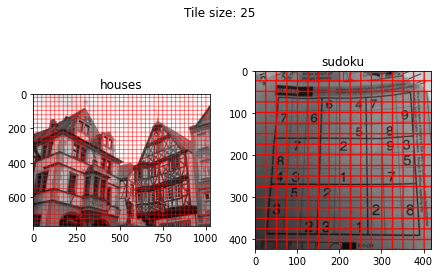

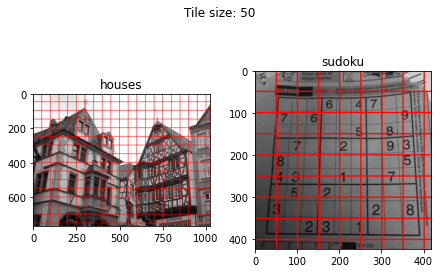

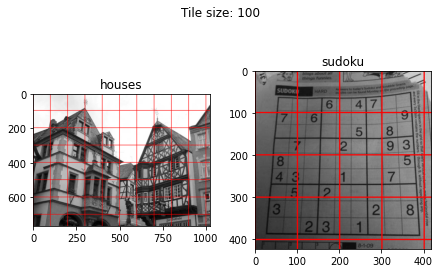

In [4]:
# Tile sizes, feel free to add more when testing
tile_sizes = [25, 50, 100]

# Red color in RGB 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2

for tile_size in tile_sizes:
    # Create empty images based on the shapes of images in img_arr
    img_arr_tiles = [cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in img_arr]

    # this loop iterates through images
    for img_index in range(0,len(img_arr)):
        column_start_value = 0
        while column_start_value < img_arr_tiles[img_index].shape[1]:
            
            # compute the vertical end value
            column_end_value = column_start_value + tile_size

            # reset/initiate the horizontal start value
            row_start_value = 0

            while row_start_value < img_arr_tiles[img_index].shape[0]:

                # compute the horizontal end value
                row_end_value = row_start_value + tile_size
                
                # draw the rectangle
                cv2.rectangle(img_arr_tiles[img_index], (column_start_value, row_start_value), (column_end_value, row_end_value), color, thickness)

                # update horizontal starting values
                row_start_value = row_end_value

            # update vertical starting values
            column_start_value = column_end_value


    # Plot results
    f, axarr = plt.subplots(1,2, constrained_layout=True)
    f.suptitle("Tile size: " + str(tile_size))
    for img, plot, title in zip(img_arr_tiles, axarr, title_arr):
        plot.imshow(img)
        plot.set_title(title)

## 2.2 Otsu Threshold
This process takes some time, you can/change the tile sizes values below if you want to play with it please be aware that a smaller tile size will drastically decrease performance size 40 has been the best looking one for me so far, but that took like 15 minutes to run.
I also noticed that choosing min and max values for thresholds would let us avoid strang blaack regions in the sky for houses. 
However I did not add those since it is not what was asked in the questions.

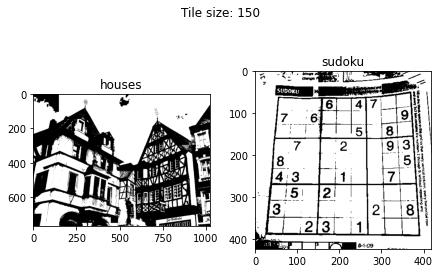

In [5]:

# modify the array here to test out different tile sizes
tile_sizes = [150]

bins = [i for i in range(0,255)]

def get_variance(bin_val_arr, hist_val_arr):

    # if the sum of values in the histograms is 0 the mean and variance are 0
    hist_val_arr_sum = sum(hist_val_arr)
    if hist_val_arr_sum == 0:
        return 0

    mean = sum([bin_val * hist_val for bin_val, hist_val in zip(bin_val_arr, hist_val_arr)]) / hist_val_arr_sum
    variance = sum([(bin_val - mean) ** 2 * hist_val for bin_val, hist_val in zip(bin_val_arr, hist_val_arr)]) / hist_val_arr_sum

    return variance

def get_mean(bin_val_arr, hist_val_arr):
    # if the sum of values in the histograms is 0 the mean is 0
    hist_val_arr_sum = sum(hist_val_arr)
    if hist_val_arr_sum == 0:
        return 0

    return sum([bin_val * hist_val for bin_val, hist_val in zip(bin_val_arr, hist_val_arr)]) / hist_val_arr_sum

def within_class_variance(threshold, histogram, total_pixel_number) -> float:
    b_weight = sum(histogram[:threshold]) / total_pixel_number
    f_weight = sum(histogram[threshold:]) / total_pixel_number

    b_variance = get_variance(bins[:threshold], histogram[:threshold])
    f_variance = get_variance(bins[threshold:], histogram[threshold:])

    # return the within class value
    return b_variance * b_weight + f_variance * f_weight

def between_class_variance(threshold, histogram, total_pixel_number) -> float:
    b_weight = sum(histogram[:threshold]) / total_pixel_number
    f_weight = sum(histogram[threshold:]) / total_pixel_number

    b_mean = get_mean(bins[:threshold], histogram[:threshold])
    f_mean = get_mean(bins[threshold:], histogram[threshold:])
    return b_weight * f_weight * (b_mean - f_mean) ** 2

def otsu_threshold(img) -> int:
    total_pixel_number = img.shape[0] * img.shape[1]

    # get histogram
    bins = [i for i in range(0,255)]
    hist, bins = np.histogram(img, bins=bins)

    # get between class variance and within class variance
    between_class_variances = [between_class_variance(threshold, hist, total_pixel_number) for threshold in range(0,255)]
    within_class_variances = [within_class_variance(threshold, hist, total_pixel_number) for threshold in range(0,255)]

    # calculate threshold with within_class_variances (because it is faster to compute)
    threshold = between_class_variances.index(max(between_class_variances))

    # if I were to compute threshold with within_class_variances I would do:
    # threshold = within_class_variances.index(min(within_class_variances))

    return threshold

def apply_threshold(threshold, value):
    if value > threshold:
        return 255
    return 0

for tile_size in tile_sizes:
    # Create empty images based on the shapes of images in img_arr
    img_arr_tiles = [np.zeros(img.shape, np.uint8) for img in img_arr]

    # this loop iterates through images
    for img_index in range(0,len(img_arr)):
        column_start_value = 0
        while column_start_value < img_arr_tiles[img_index].shape[1]:
            
            # compute the vertical end value
            column_end_value = column_start_value + tile_size
            if column_end_value > img_arr_tiles[img_index].shape[1]:
                    column_end_value = img_arr_tiles[img_index].shape[1]

            # reset/initiate the horizontal start value
            row_start_value = 0

            while row_start_value < img_arr_tiles[img_index].shape[0]:

                # compute the horizontal end value
                row_end_value = row_start_value + tile_size

                if row_end_value > img_arr_tiles[img_index].shape[0]:
                    row_end_value = img_arr_tiles[img_index].shape[0]

                # get the otsu threshold
                threshold = otsu_threshold(img_arr[img_index][row_start_value:row_end_value,column_start_value:column_end_value])

                # add the thresholded section:
                # in here we select a section of the image: [row_start_value:row_end_value,column_start_value:column_end_value], and we generate its thresholded value using the apply_threshold,
                # then, it gets replaced.
                img_arr_tiles[img_index][row_start_value:row_end_value,column_start_value:column_end_value] = [[apply_threshold(threshold, value) for value in row] for row in img_arr[img_index][row_start_value:row_end_value,column_start_value:column_end_value]]

                # update horizontal starting values
                row_start_value = row_end_value

            # update vertical starting values
            column_start_value = column_end_value
            
    # Plot  results
    f, axarr = plt.subplots(1,2, constrained_layout=True)
    f.suptitle("Tile size: " + str(tile_size))
    for img, plot, title in zip(img_arr_tiles, axarr, title_arr):
        plot.imshow(img, cmap = 'gray')
        plot.set_title(title)


## 2.3 Thresholding RGB images

(1478, 1200, 3)


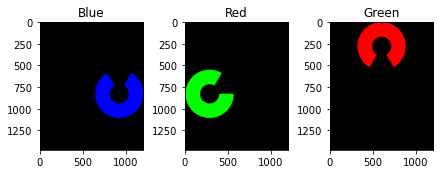

In [6]:

cv_img = cv2.imread("OCVLogo.png")
print(cv_img.shape)
# Create 3 empty images
filtered_images = [np.zeros(cv_img.shape, np.uint8) for i in range(cv_img.shape[2])]
filtered_img_titles= ["Blue", "Red", "Green"]

# Put subpixel value in each image
for row in range (cv_img.shape[0]-1):
    for column in range(cv_img.shape[1]-1):
        for color in range(cv_img.shape[2]):
            # Assign the value of the color to its matching image
            filtered_images[color][row][column][color] = apply_threshold(127, cv_img[row][column][color])

# Plot results
f, axarr = plt.subplots(1,3, constrained_layout=True)
for img, plot, title in zip(filtered_images, axarr, filtered_img_titles):
    plot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plot.set_title(title)